Contrastive Loss was introduced by Yann Le Cunn et al. in the paper http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [5]:
import numpy as np

# Load the MNIST dataset locally
with np.load('mnist.npz', allow_pickle=True) as f:
    X_train, y_train = f['x_train'], f['y_train']
    X_test, y_test = f['x_test'], f['y_test']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


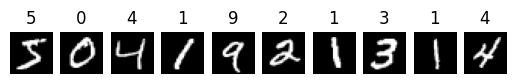

In [6]:
import matplotlib.pyplot as plt


for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

In [8]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

We'll train a Siamese Network using positive and negative pairs of images. A positive pair consists of two images representing the same digit, while a negative pair consists of two images representing different digits.

In [10]:
import numpy as np


def generate_pairs(X, y):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a random image representing the same digit.
        # This is a positive pair.
        positive_digit_index = np.random.choice(np.where(y == digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[positive_digit_index]])

        # Since this is a positive pair, the ground truth label is 0.
        # The distance between images representing the same digit should be small,
        # and that's why we use 0 as the label.
        y_pairs.append([0])

        # Find a random image representing a different digit.
        # This is a negative pair.
        negative_digit_index = np.random.choice(np.where(y != digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[negative_digit_index]])

        # Since this is a negative pair, the ground truth label is 1.
        # The distance between images representing different digits should be large,
        # and that's why we use 1 as the label.
        y_pairs.append([1])

    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [11]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


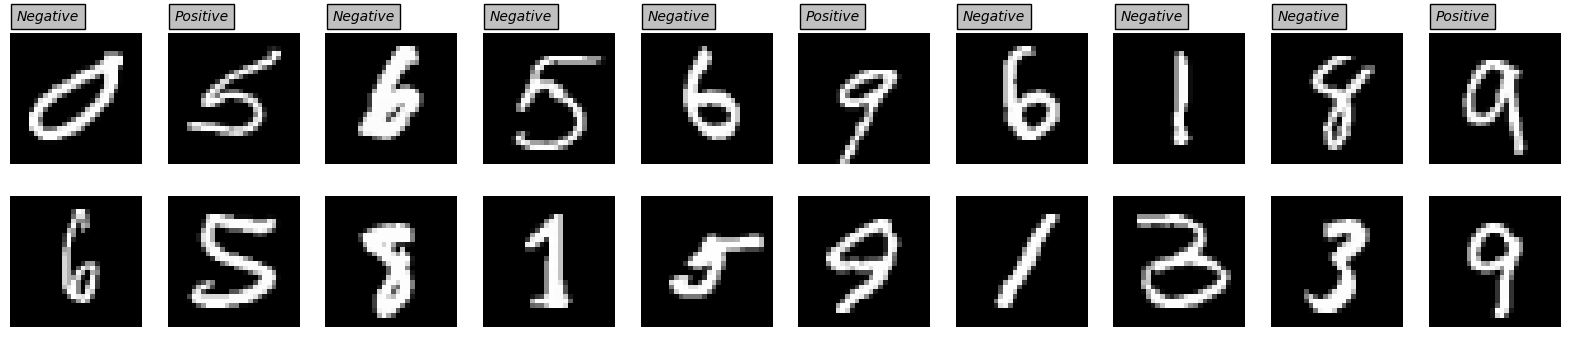

In [12]:
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(X_train_pairs, y_train_pairs)

In [13]:
from keras import Input

input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

In [14]:
from keras.layers import Dense
from keras.models import Sequential

network = Sequential(
    [
        Input(shape=(784,)),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation=None),
    ]
)

In [15]:
twin1 = network(input1)
twin2 = network(input2)

In [16]:
from keras.layers import Lambda
from keras.ops import norm


def euclidean_distance(twins):
    """Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)


distance = Lambda(euclidean_distance)([twin1, twin2])

In [17]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

We'll use the Contrastive Loss to train the model

In [18]:
from keras.ops import cast, maximum, square


def contrastive_loss(y, d):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """

    margin = 1
    y = cast(y, d.dtype)

    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))

    return loss

In [19]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

In [ ]:
keras.utils.plot_model(
    model, to_file="model.png", show_shapes=True, show_layer_names=False
)

In [27]:
history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.8868 - loss: 0.0514 - val_binary_accuracy: 0.9631 - val_loss: 0.0210
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9733 - loss: 0.0166 - val_binary_accuracy: 0.9668 - val_loss: 0.0166
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9834 - loss: 0.0112 - val_binary_accuracy: 0.9656 - val_loss: 0.0165
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9886 - loss: 0.0084 - val_binary_accuracy: 0.9711 - val_loss: 0.0144
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9908 - loss: 0.0071 - val_binary_accuracy: 0.9700 - val_loss: 0.0144


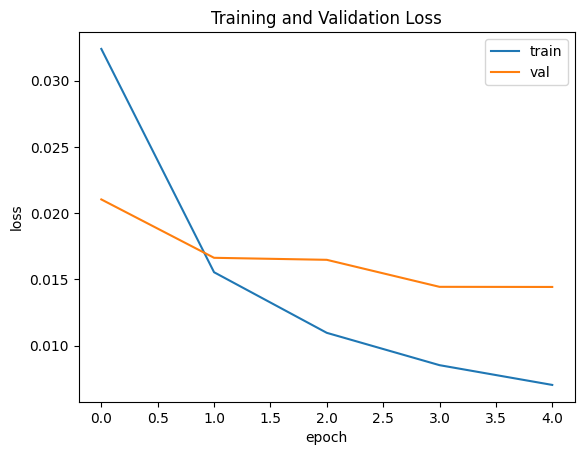

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step


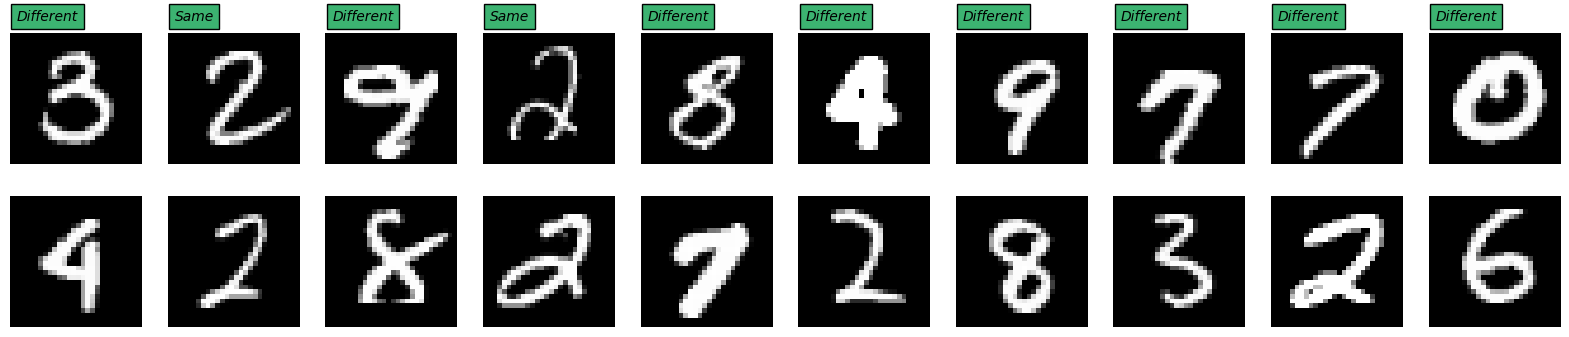

In [29]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5
display_pairs(X_test_pairs, predictions, predictions == y_test_pairs)

In [30]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97


In [31]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

In [34]:
embedding_model = model.layers[2]

In [35]:
digits = np.where(y_test == 3)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 7)[0])

index1, index2, index3

(8674, 8032, 9248)

In [36]:
embedding1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [37]:
norm(embedding1 - embedding2).numpy()

0.027460957

In [38]:
norm(embedding1 - embedding3).numpy(), norm(embedding2 - embedding3).numpy()

(1.1097815, 1.1325307)